1. 数据合并和基本信息查看

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
ds_accum = xr.open_dataset('data/data_stream-oper_stepType-accum.nc')
ds_instant = xr.open_dataset('data/data_stream-oper_stepType-instant.nc')
ds_combined = xr.merge([ds_accum, ds_instant])

print("合并后的数据集信息:")
print("包含变量:", list(ds_combined.data_vars))
print("时间范围:", ds_combined.valid_time.min().values, "到", ds_combined.valid_time.max().values)
print("数据大小:", f"{ds_combined.nbytes/1e9:.2f} GB")
print("地理范围:")
print(f"  经度: {ds_combined.longitude.min().values}° 到 {ds_combined.longitude.max().values}°")
print(f"  纬度: {ds_combined.latitude.min().values}° 到 {ds_combined.latitude.max().values}°")
print("(数据覆盖欧洲及周边地区)")

合并后的数据集信息:
包含变量: ['tp', 'u10', 'v10', 'd2m', 't2m', 'msl']
时间范围: 2020-01-01T00:00:00.000000000 到 2020-12-31T18:00:00.000000000
数据大小: 0.85 GB
地理范围:
  经度: -10.0° 到 40.0°
  纬度: 30.0° 到 60.0°
(数据覆盖欧洲及周边地区)


2. 选择欧洲典型城市进行分析


In [3]:
# 选择一个欧洲城市作为分析点，比如巴黎附近 (北纬48.8°, 东经2.3°)
# 或者选择数据范围内的中心点
paris_lat = 48.8
paris_lon = 2.3

# 选择最接近的格点
ds_europe = ds_combined.sel(
    latitude=paris_lat,
    longitude=paris_lon,
    method='nearest'
)

print("选中的欧洲分析点坐标:")
print("纬度:", ds_europe.latitude.values)
print("经度:", ds_europe.longitude.values)
print("(大约位于西欧地区)")

选中的欧洲分析点坐标:
纬度: 48.75
经度: 2.25
(大约位于西欧地区)


3. 数据预处理和单位转换


In [4]:
# 创建处理后的数据集
ds_processed = ds_europe.copy()

# 单位转换
ds_processed['tp_mm'] = ds_processed['tp'] * 1000  # m转mm
ds_processed['t2m_c'] = ds_processed['t2m'] - 273.15  # K转°C
ds_processed['d2m_c'] = ds_processed['d2m'] - 273.15  # K转°C
ds_processed['msl_hpa'] = ds_processed['msl'] / 100  # Pa转hPa
ds_processed['wind_speed'] = np.sqrt(ds_processed['u10']**2 + ds_processed['v10']**2)  # 计算风速大小

print("欧洲地区2020年气象要素统计:")
print(f"降水量(mm): 均值{ds_processed['tp_mm'].mean().values:.4f}, 最大值{ds_processed['tp_mm'].max().values:.4f}")
print(f"2m温度(°C): 均值{ds_processed['t2m_c'].mean().values:.2f}, 范围{ds_processed['t2m_c'].min().values:.2f}到{ds_processed['t2m_c'].max().values:.2f}")
print(f"露点温度(°C): 均值{ds_processed['d2m_c'].mean().values:.2f}")
print(f"气压(hPa): 均值{ds_processed['msl_hpa'].mean().values:.2f}")
print(f"风速(m/s): 均值{ds_processed['wind_speed'].mean().values:.2f}, 最大值{ds_processed['wind_speed'].max().values:.2f}")

欧洲地区2020年气象要素统计:
降水量(mm): 均值0.0790, 最大值3.3727
2m温度(°C): 均值12.85, 范围-3.01到36.82
露点温度(°C): 均值7.81
气压(hPa): 均值1016.67
风速(m/s): 均值3.83, 最大值12.66


4. 时间序列分析

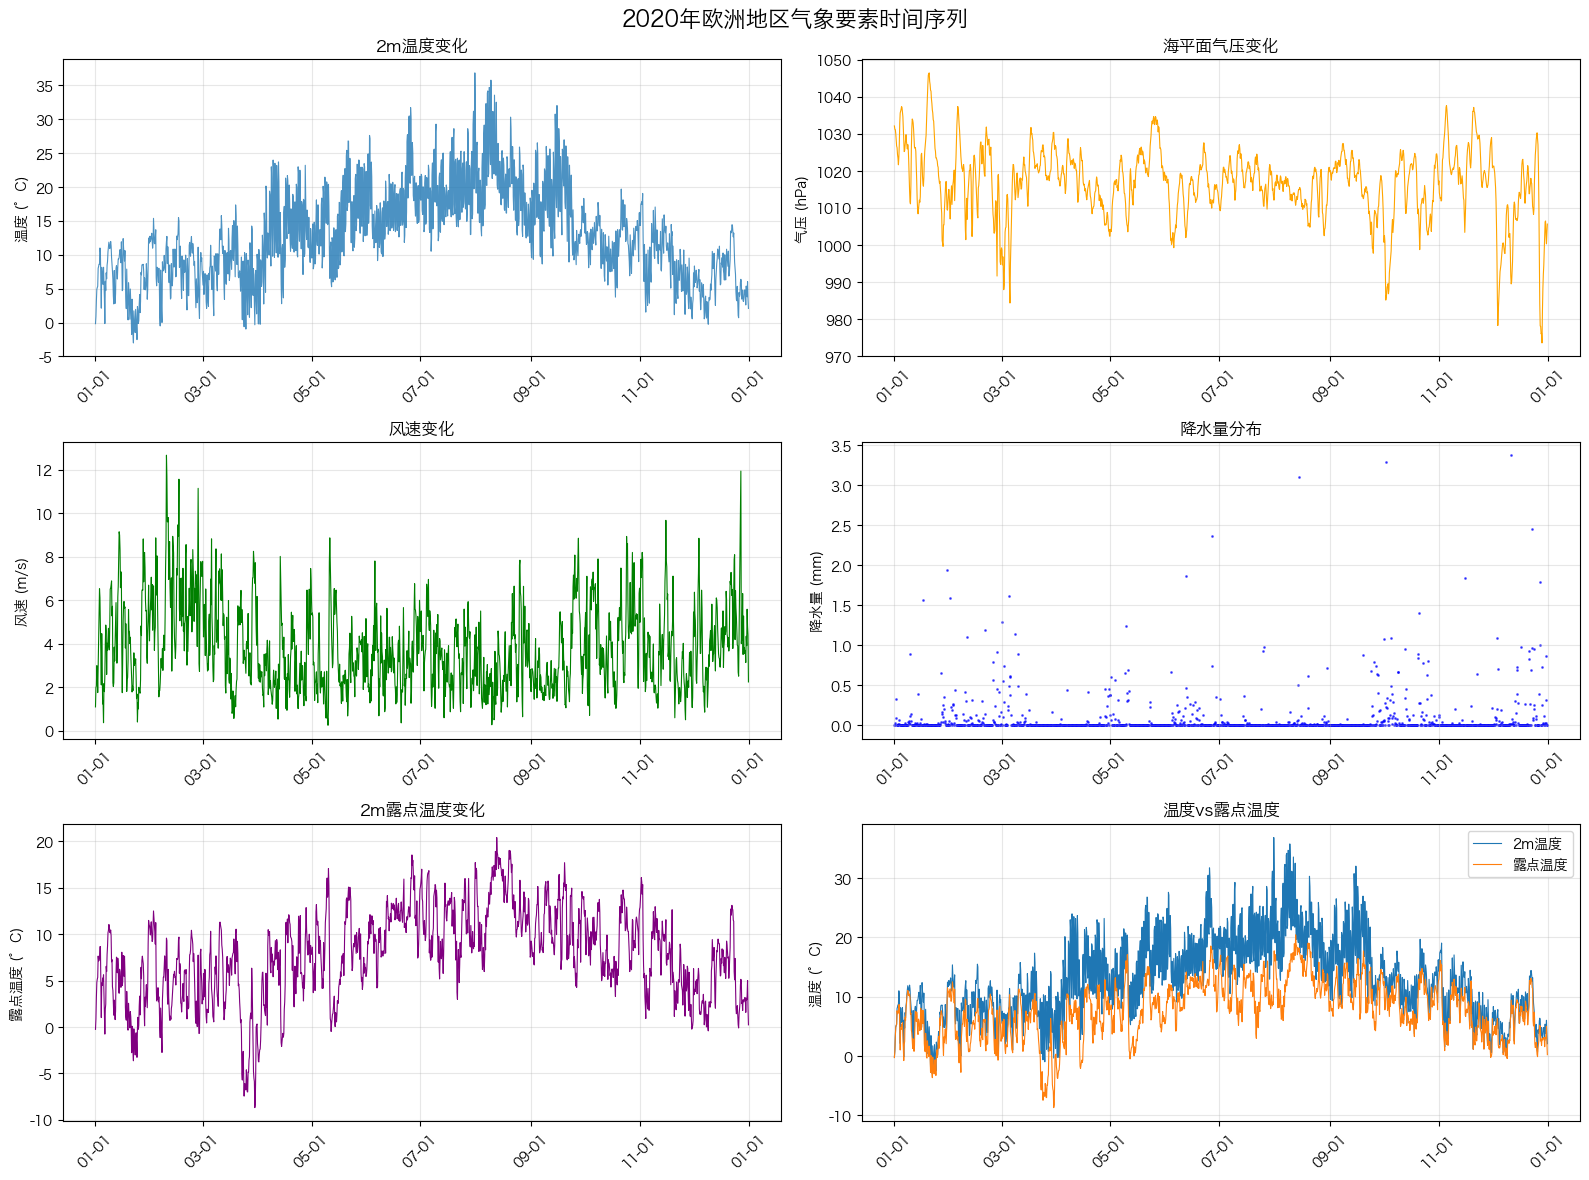

In [6]:
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Hiragino Sans GB', 'Songti SC']
plt.rcParams['axes.unicode_minus'] = False

# 将xarray转换为pandas便于时间序列分析
df = ds_processed.to_dataframe().reset_index()

# 创建图形
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('2020年欧洲地区气象要素时间序列', fontsize=16)

# 1. 温度时间序列
axes[0,0].plot(df['valid_time'], df['t2m_c'], linewidth=0.8, alpha=0.8)
axes[0,0].set_title('2m温度变化')
axes[0,0].set_ylabel('温度 (°C)')
axes[0,0].grid(True, alpha=0.3)

# 2. 气压时间序列
axes[0,1].plot(df['valid_time'], df['msl_hpa'], linewidth=0.8, color='orange')
axes[0,1].set_title('海平面气压变化')
axes[0,1].set_ylabel('气压 (hPa)')
axes[0,1].grid(True, alpha=0.3)

# 3. 风速时间序列
axes[1,0].plot(df['valid_time'], df['wind_speed'], linewidth=0.8, color='green')
axes[1,0].set_title('风速变化')
axes[1,0].set_ylabel('风速 (m/s)')
axes[1,0].grid(True, alpha=0.3)

# 4. 降水时间序列
axes[1,1].scatter(df['valid_time'], df['tp_mm'], s=1, alpha=0.6, color='blue')
axes[1,1].set_title('降水量分布')
axes[1,1].set_ylabel('降水量 (mm)')
axes[1,1].grid(True, alpha=0.3)

# 5. 露点温度
axes[2,0].plot(df['valid_time'], df['d2m_c'], linewidth=0.8, color='purple')
axes[2,0].set_title('2m露点温度变化')
axes[2,0].set_ylabel('露点温度 (°C)')
axes[2,0].grid(True, alpha=0.3)

# 6. 温度和露点温度对比
axes[2,1].plot(df['valid_time'], df['t2m_c'], label='2m温度', linewidth=0.8)
axes[2,1].plot(df['valid_time'], df['d2m_c'], label='露点温度', linewidth=0.8)
axes[2,1].set_title('温度vs露点温度')
axes[2,1].set_ylabel('温度 (°C)')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# 设置x轴格式
for ax in axes.flat:
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

	b. 季节性和周期性分析

In [7]:
# 添加更多时间特征
df['month'] = df['valid_time'].dt.month
df['day_of_year'] = df['valid_time'].dt.dayofyear
df['hour'] = df['valid_time'].dt.hour
df['season'] = df['month'].map({12:1, 1:1, 2:1,  # 冬季
                                3:2, 4:2, 5:2,   # 春季
                                6:3, 7:3, 8:3,   # 夏季
                                9:4, 10:4, 11:4}) # 秋季

season_names = {1:'冬季', 2:'春季', 3:'夏季', 4:'秋季'}
df['season_name'] = df['season'].map(season_names)

# 季节性统计分析
print("=== 季节性统计分析 ===")
seasonal_stats = df.groupby('season_name')[['t2m_c', 'msl_hpa', 'wind_speed', 'tp_mm']].agg(['mean', 'std', 'max', 'min'])
print(seasonal_stats.round(2))

=== 季节性统计分析 ===
             t2m_c                             msl_hpa                      \
              mean   std        max   min         mean    std          max   
season_name                                                                  
冬季            6.86  3.68  15.480000 -3.01  1016.219971  13.23  1046.489990   
夏季           19.58  5.35  36.820000  9.13  1015.309998   5.43  1027.609985   
春季           12.16  5.89  26.780001 -0.96  1017.940002   8.29  1034.680054   
秋季           12.72  5.65  32.000000  0.55  1017.210022   9.41  1037.670044   

                        wind_speed                    tp_mm                   
                    min       mean   std    max   min  mean   std   max  min  
season_name                                                                   
冬季           973.539978       4.86  2.14  12.66  0.36  0.12  0.34  3.37  0.0  
夏季           999.270020       3.22  1.44   7.84  0.27  0.05  0.25  3.10  0.0  
春季           984.320007       3.55  1.80  

	a. 日变化规律分析


=== 日变化规律分析 ===
各时次平均值:
      t2m_c      msl_hpa  wind_speed
hour                                
0     10.63  1017.030029        3.60
6      9.89  1016.789978        3.69
12    15.96  1016.729980        4.26
18    14.91  1016.130005        3.77


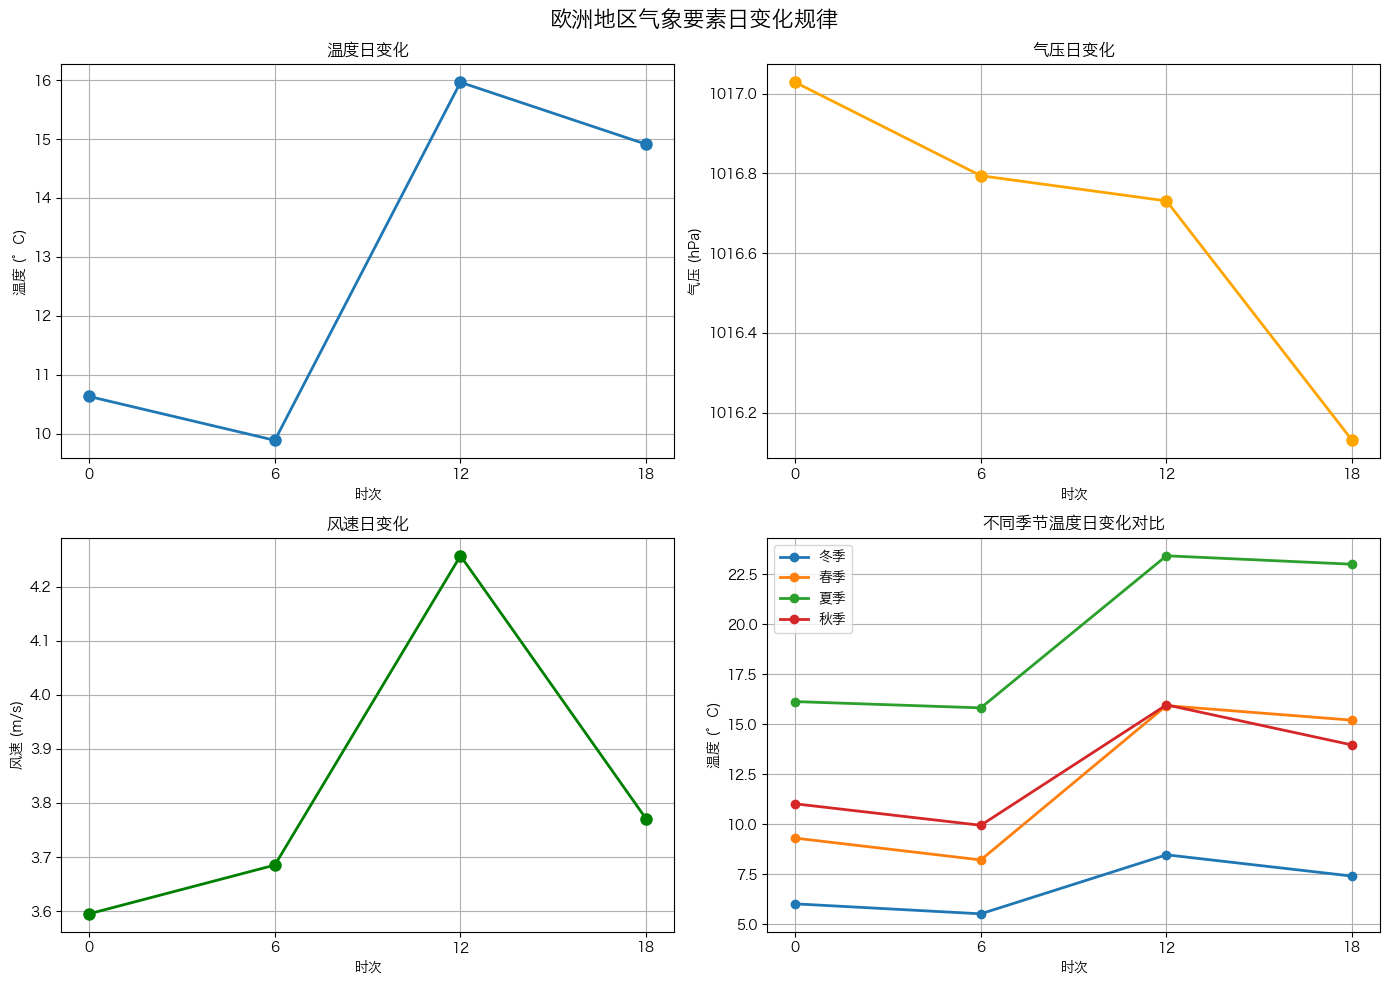

In [8]:
# 分析日变化规律（6小时数据：0时、6时、12时、18时）
print("\n=== 日变化规律分析 ===")
hourly_stats = df.groupby('hour')[['t2m_c', 'msl_hpa', 'wind_speed']].mean()
print("各时次平均值:")
print(hourly_stats.round(2))

# 可视化日变化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('欧洲地区气象要素日变化规律', fontsize=16)

# 温度日变化
axes[0,0].plot(hourly_stats.index, hourly_stats['t2m_c'], 'o-', linewidth=2, markersize=8)
axes[0,0].set_title('温度日变化')
axes[0,0].set_xlabel('时次')
axes[0,0].set_ylabel('温度 (°C)')
axes[0,0].set_xticks([0, 6, 12, 18])
axes[0,0].grid(True)

# 气压日变化
axes[0,1].plot(hourly_stats.index, hourly_stats['msl_hpa'], 'o-', color='orange', linewidth=2, markersize=8)
axes[0,1].set_title('气压日变化')
axes[0,1].set_xlabel('时次')
axes[0,1].set_ylabel('气压 (hPa)')
axes[0,1].set_xticks([0, 6, 12, 18])
axes[0,1].grid(True)

# 风速日变化
axes[1,0].plot(hourly_stats.index, hourly_stats['wind_speed'], 'o-', color='green', linewidth=2, markersize=8)
axes[1,0].set_title('风速日变化')
axes[1,0].set_xlabel('时次')
axes[1,0].set_ylabel('风速 (m/s)')
axes[1,0].set_xticks([0, 6, 12, 18])
axes[1,0].grid(True)

# 温度季节对比
for season in [1, 2, 3, 4]:
    season_data = df[df['season'] == season].groupby('hour')['t2m_c'].mean()
    axes[1,1].plot(season_data.index, season_data.values, 'o-', 
                   label=season_names[season], linewidth=2, markersize=6)
axes[1,1].set_title('不同季节温度日变化对比')
axes[1,1].set_xlabel('时次')
axes[1,1].set_ylabel('温度 (°C)')
axes[1,1].set_xticks([0, 6, 12, 18])
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

	c. 月变化趋势分析


=== 月变化趋势分析 ===
各月统计:
           t2m_c            msl_hpa        wind_speed       tp_mm      
            mean   std         mean    std       mean   std  mean   std
month                                                                  
1       6.040000  3.93  1024.160034  10.54       4.17  2.01  0.07  0.25
2       8.300000  3.40  1017.760010   9.37       5.97  2.22  0.10  0.25
3       7.830000  3.84  1017.229980  10.02       4.37  1.93  0.09  0.26
4      13.520000  5.62  1016.109985   5.94       3.02  1.51  0.03  0.10
5      15.180000  5.32  1020.440002   7.78       3.22  1.64  0.06  0.17
6      17.620001  4.81  1013.780029   6.36       3.27  1.39  0.09  0.29
7      19.809999  4.89  1018.239990   4.07       3.38  1.37  0.03  0.13
8      21.260000  5.69  1013.859985   4.39       3.01  1.54  0.05  0.29
9      17.420000  5.61  1016.880005   6.59       3.21  1.75  0.05  0.17
10     11.870000  2.98  1011.969971  10.46       4.44  1.87  0.16  0.39
11      8.910000  4.38  1022.950012   7.1

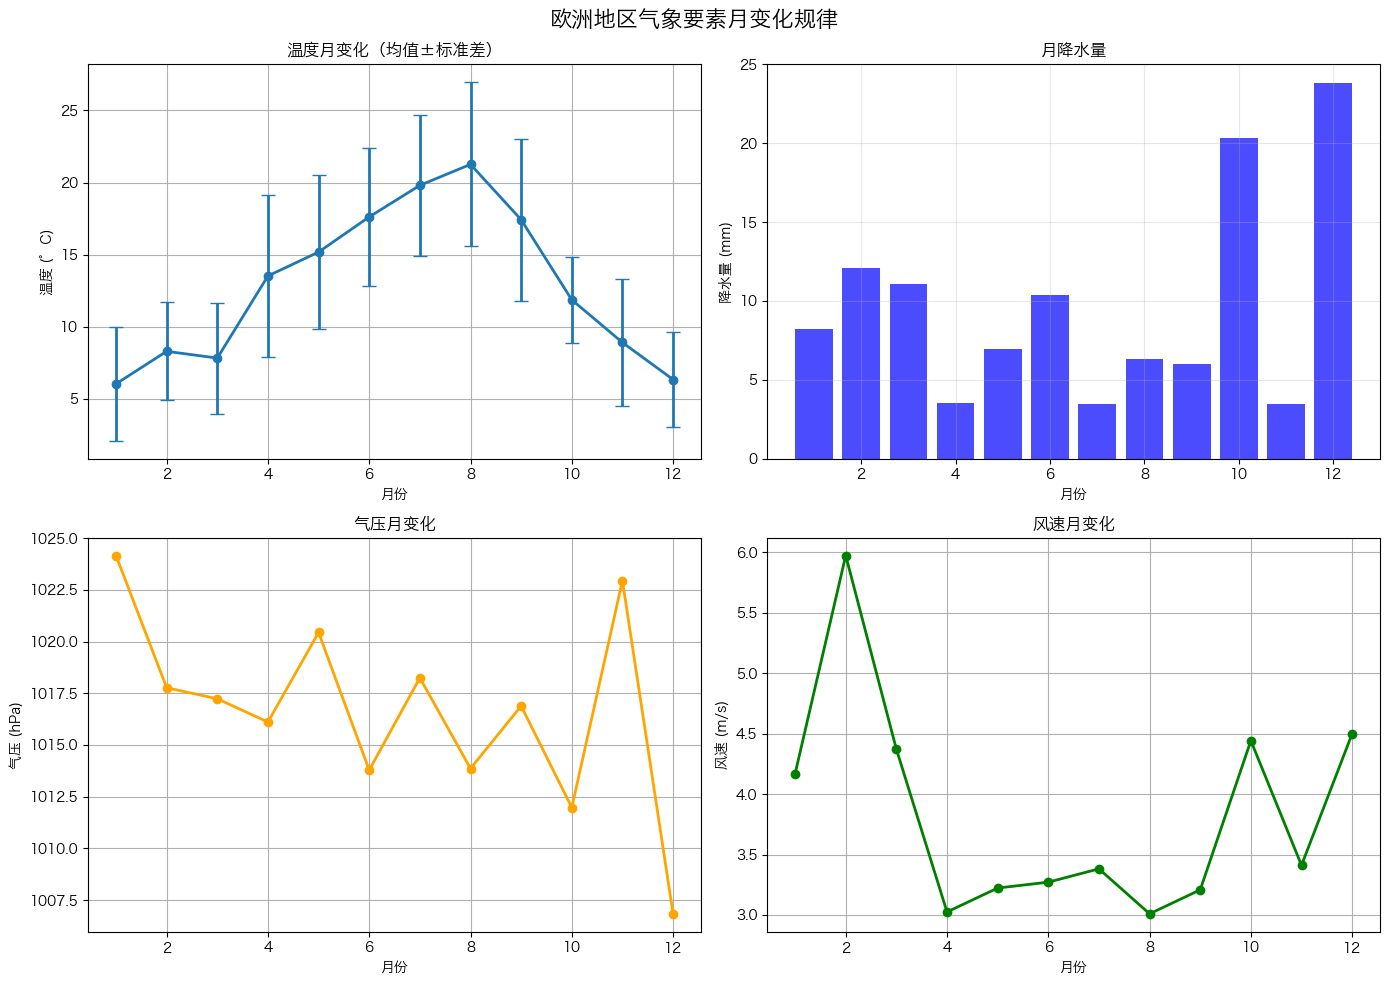

In [9]:
# 月变化分析
print("\n=== 月变化趋势分析 ===")
monthly_stats = df.groupby('month')[['t2m_c', 'msl_hpa', 'wind_speed', 'tp_mm']].agg(['mean', 'std'])
print("各月统计:")
print(monthly_stats.round(2))

# 可视化月变化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('欧洲地区气象要素月变化规律', fontsize=16)

months = range(1, 13)
month_names = ['1月', '2月', '3月', '4月', '5月', '6月', 
               '7月', '8月', '9月', '10月', '11月', '12月']

# 温度月变化（含标准差）
monthly_temp_mean = monthly_stats['t2m_c']['mean']
monthly_temp_std = monthly_stats['t2m_c']['std']
axes[0,0].errorbar(months, monthly_temp_mean, yerr=monthly_temp_std, 
                   fmt='o-', capsize=5, linewidth=2, markersize=6)
axes[0,0].set_title('温度月变化（均值±标准差）')
axes[0,0].set_xlabel('月份')
axes[0,0].set_ylabel('温度 (°C)')
axes[0,0].grid(True)

# 降水月变化
monthly_precip = df.groupby('month')['tp_mm'].sum()  # 月总降水量
axes[0,1].bar(months, monthly_precip, alpha=0.7, color='blue')
axes[0,1].set_title('月降水量')
axes[0,1].set_xlabel('月份')
axes[0,1].set_ylabel('降水量 (mm)')
axes[0,1].grid(True, alpha=0.3)

# 气压月变化
monthly_pressure = monthly_stats['msl_hpa']['mean']
axes[1,0].plot(months, monthly_pressure, 'o-', color='orange', linewidth=2, markersize=6)
axes[1,0].set_title('气压月变化')
axes[1,0].set_xlabel('月份')
axes[1,0].set_ylabel('气压 (hPa)')
axes[1,0].grid(True)

# 风速月变化
monthly_wind = monthly_stats['wind_speed']['mean']
axes[1,1].plot(months, monthly_wind, 'o-', color='green', linewidth=2, markersize=6)
axes[1,1].set_title('风速月变化')
axes[1,1].set_xlabel('月份')
axes[1,1].set_ylabel('风速 (m/s)')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

6. 相关性矩阵分析

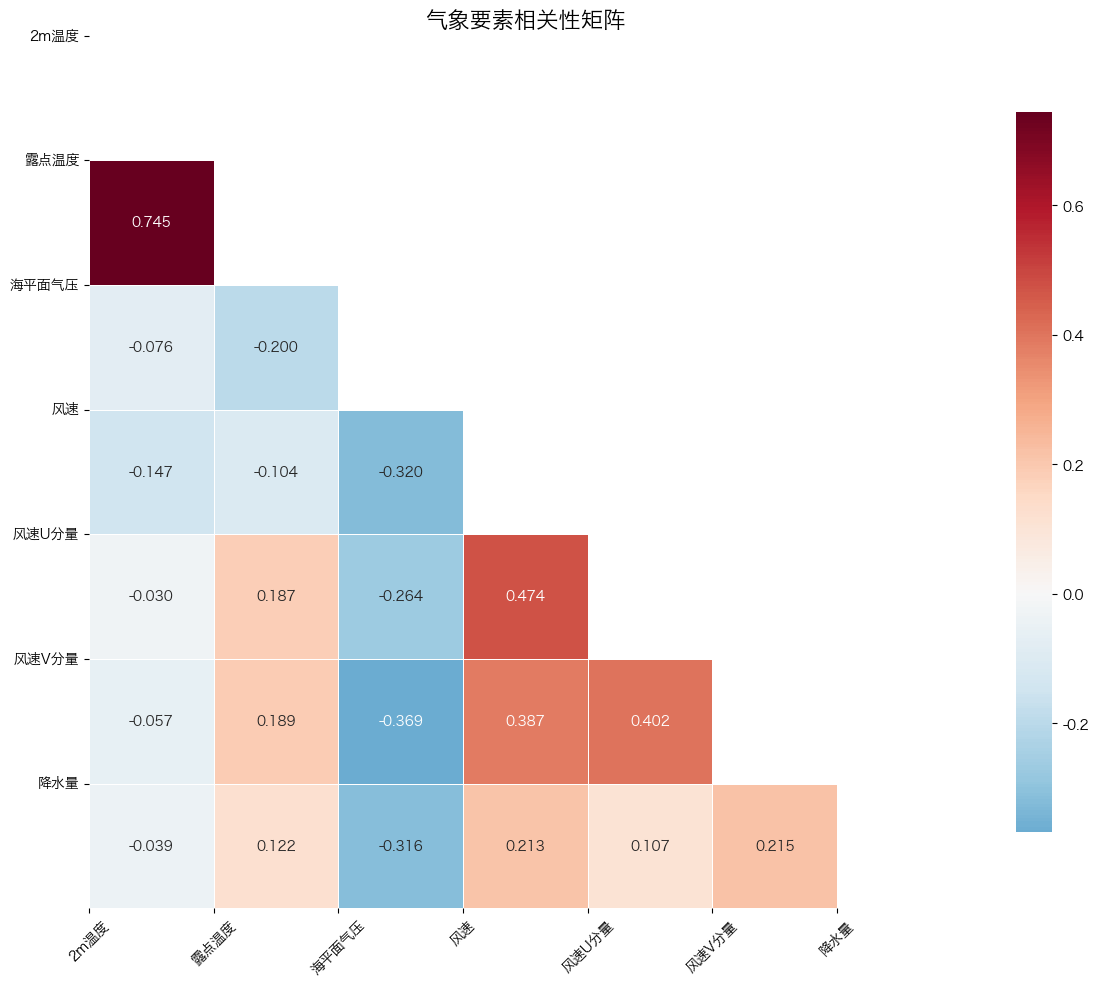

=== 相关性矩阵分析结果 ===
            t2m_c  d2m_c  msl_hpa  wind_speed    u10    v10  tp_mm
t2m_c       1.000  0.745   -0.076      -0.147 -0.030 -0.057 -0.039
d2m_c       0.745  1.000   -0.200      -0.104  0.187  0.189  0.122
msl_hpa    -0.076 -0.200    1.000      -0.320 -0.264 -0.369 -0.316
wind_speed -0.147 -0.104   -0.320       1.000  0.474  0.387  0.213
u10        -0.030  0.187   -0.264       0.474  1.000  0.402  0.107
v10        -0.057  0.189   -0.369       0.387  0.402  1.000  0.215
tp_mm      -0.039  0.122   -0.316       0.213  0.107  0.215  1.000


In [11]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# 选择主要气象变量进行相关性分析
correlation_vars = ['t2m_c', 'd2m_c', 'msl_hpa', 'wind_speed', 'u10', 'v10', 'tp_mm']
var_names_zh = ['2m温度', '露点温度', '海平面气压', '风速', '风速U分量', '风速V分量', '降水量']

# 计算相关性矩阵
correlation_data = df[correlation_vars]
corr_matrix = correlation_data.corr()

# 可视化相关性矩阵
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 只显示下三角
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f')
plt.title('气象要素相关性矩阵', fontsize=16)
plt.xticks(range(len(var_names_zh)), var_names_zh, rotation=45)
plt.yticks(range(len(var_names_zh)), var_names_zh, rotation=0)
plt.tight_layout()
plt.show()

print("=== 相关性矩阵分析结果 ===")
print(corr_matrix.round(3))

	a. 重要相关关系的详细分析

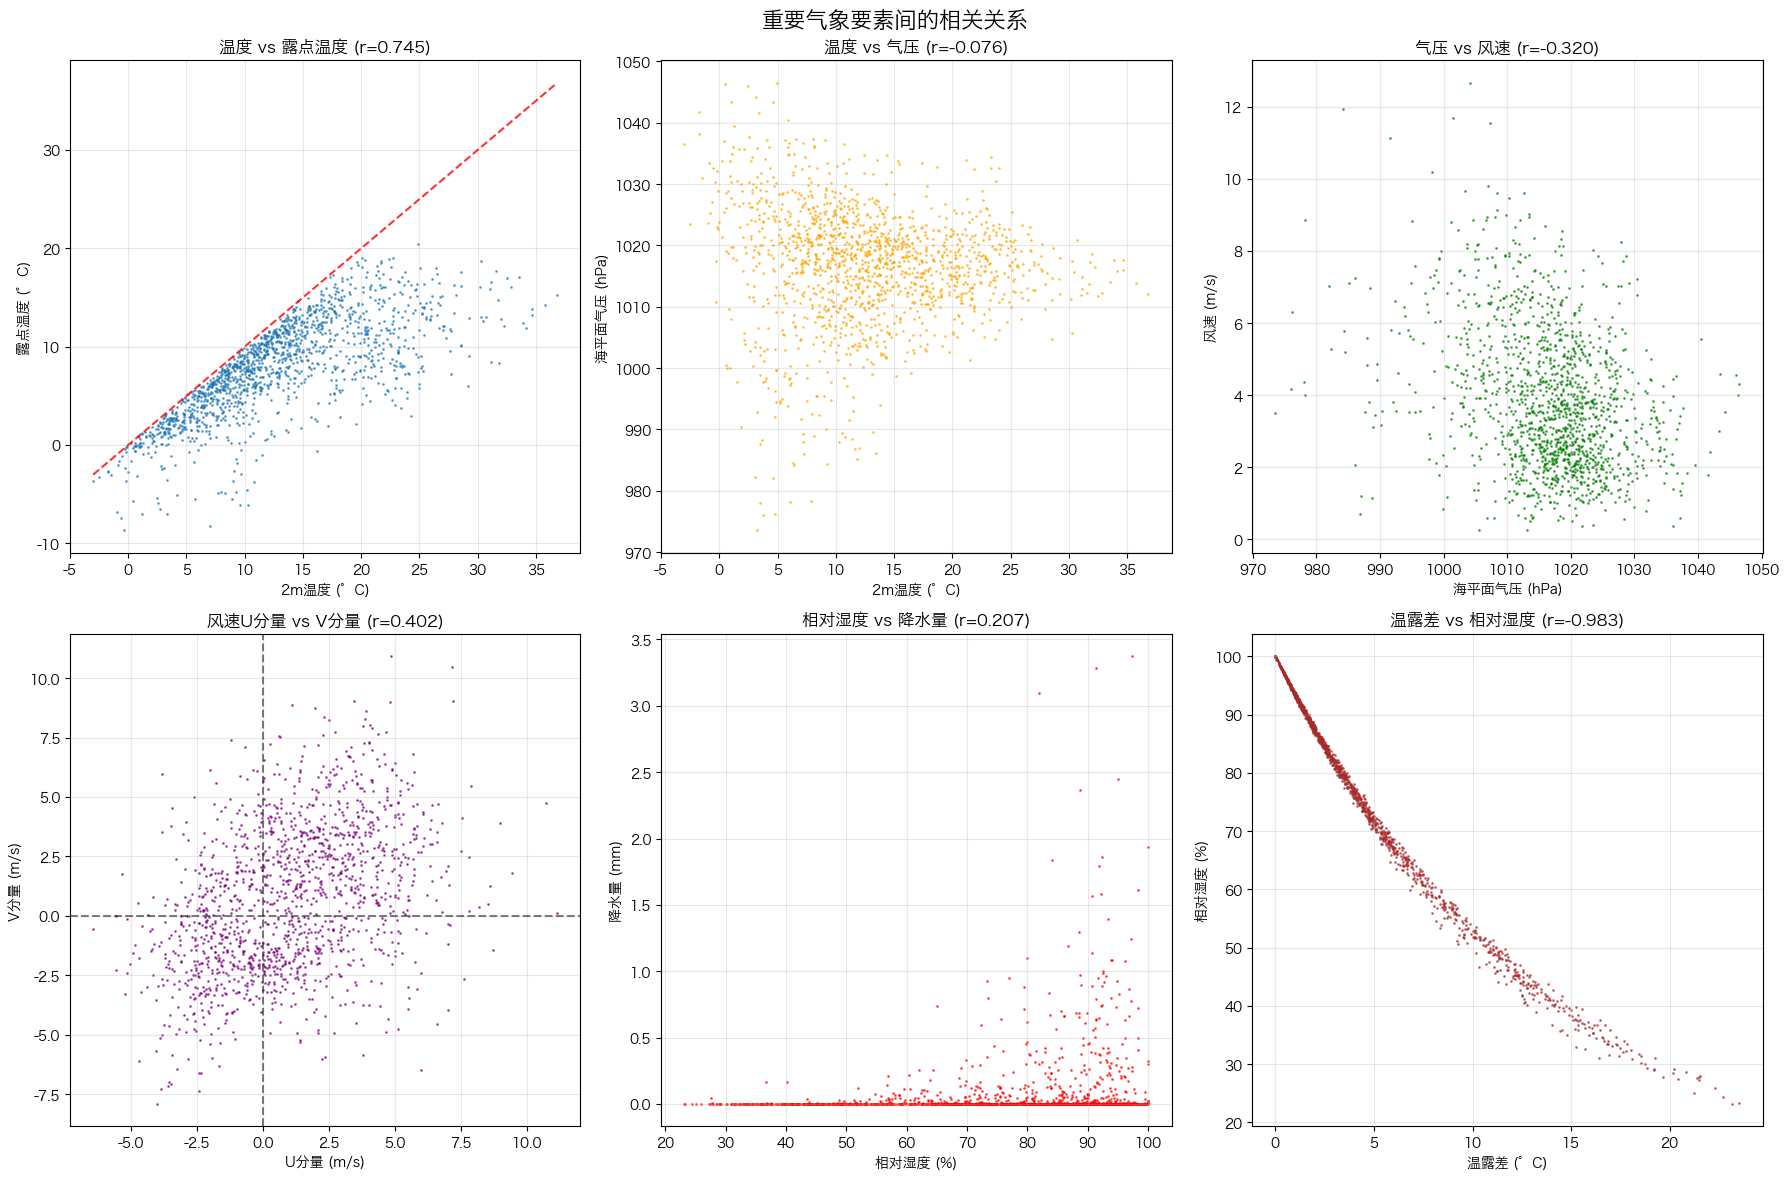

In [12]:
# 分析几个重要的相关关系
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('重要气象要素间的相关关系', fontsize=16)

# 1. 温度 vs 露点温度
axes[0,0].scatter(df['t2m_c'], df['d2m_c'], alpha=0.6, s=1)
axes[0,0].plot([df['t2m_c'].min(), df['t2m_c'].max()], 
               [df['t2m_c'].min(), df['t2m_c'].max()], 'r--', alpha=0.8)
corr_temp_dew = df['t2m_c'].corr(df['d2m_c'])
axes[0,0].set_title(f'温度 vs 露点温度 (r={corr_temp_dew:.3f})')
axes[0,0].set_xlabel('2m温度 (°C)')
axes[0,0].set_ylabel('露点温度 (°C)')
axes[0,0].grid(True, alpha=0.3)

# 2. 温度 vs 气压
axes[0,1].scatter(df['t2m_c'], df['msl_hpa'], alpha=0.6, s=1, color='orange')
corr_temp_pressure = df['t2m_c'].corr(df['msl_hpa'])
axes[0,1].set_title(f'温度 vs 气压 (r={corr_temp_pressure:.3f})')
axes[0,1].set_xlabel('2m温度 (°C)')
axes[0,1].set_ylabel('海平面气压 (hPa)')
axes[0,1].grid(True, alpha=0.3)

# 3. 气压 vs 风速
axes[0,2].scatter(df['msl_hpa'], df['wind_speed'], alpha=0.6, s=1, color='green')
corr_pressure_wind = df['msl_hpa'].corr(df['wind_speed'])
axes[0,2].set_title(f'气压 vs 风速 (r={corr_pressure_wind:.3f})')
axes[0,2].set_xlabel('海平面气压 (hPa)')
axes[0,2].set_ylabel('风速 (m/s)')
axes[0,2].grid(True, alpha=0.3)

# 4. 风速U分量 vs V分量
axes[1,0].scatter(df['u10'], df['v10'], alpha=0.6, s=1, color='purple')
corr_uv = df['u10'].corr(df['v10'])
axes[1,0].set_title(f'风速U分量 vs V分量 (r={corr_uv:.3f})')
axes[1,0].set_xlabel('U分量 (m/s)')
axes[1,0].set_ylabel('V分量 (m/s)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1,0].axvline(x=0, color='k', linestyle='--', alpha=0.5)

# 5. 计算相对湿度并分析
df['relative_humidity'] = 100 * np.exp((17.625 * df['d2m_c']) / (243.04 + df['d2m_c'])) / np.exp((17.625 * df['t2m_c']) / (243.04 + df['t2m_c']))
axes[1,1].scatter(df['relative_humidity'], df['tp_mm'], alpha=0.6, s=1, color='red')
corr_rh_precip = df['relative_humidity'].corr(df['tp_mm'])
axes[1,1].set_title(f'相对湿度 vs 降水量 (r={corr_rh_precip:.3f})')
axes[1,1].set_xlabel('相对湿度 (%)')
axes[1,1].set_ylabel('降水量 (mm)')
axes[1,1].grid(True, alpha=0.3)

# 6. 温度差（温度-露点温度）vs 相对湿度
df['temp_dewpoint_diff'] = df['t2m_c'] - df['d2m_c']
axes[1,2].scatter(df['temp_dewpoint_diff'], df['relative_humidity'], alpha=0.6, s=1, color='brown')
corr_temp_diff_rh = df['temp_dewpoint_diff'].corr(df['relative_humidity'])
axes[1,2].set_title(f'温露差 vs 相对湿度 (r={corr_temp_diff_rh:.3f})')
axes[1,2].set_xlabel('温露差 (°C)')
axes[1,2].set_ylabel('相对湿度 (%)')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

	a. 分季节相关性分析


=== 分季节相关性分析 ===

冬季相关性:
温度-露点温度: 0.899
温度-气压: -0.137
气压-风速: -0.353

春季相关性:
温度-露点温度: 0.647
温度-气压: 0.091
气压-风速: -0.244

夏季相关性:
温度-露点温度: 0.292
温度-气压: -0.043
气压-风速: -0.192

秋季相关性:
温度-露点温度: 0.775
温度-气压: -0.173
气压-风速: -0.478


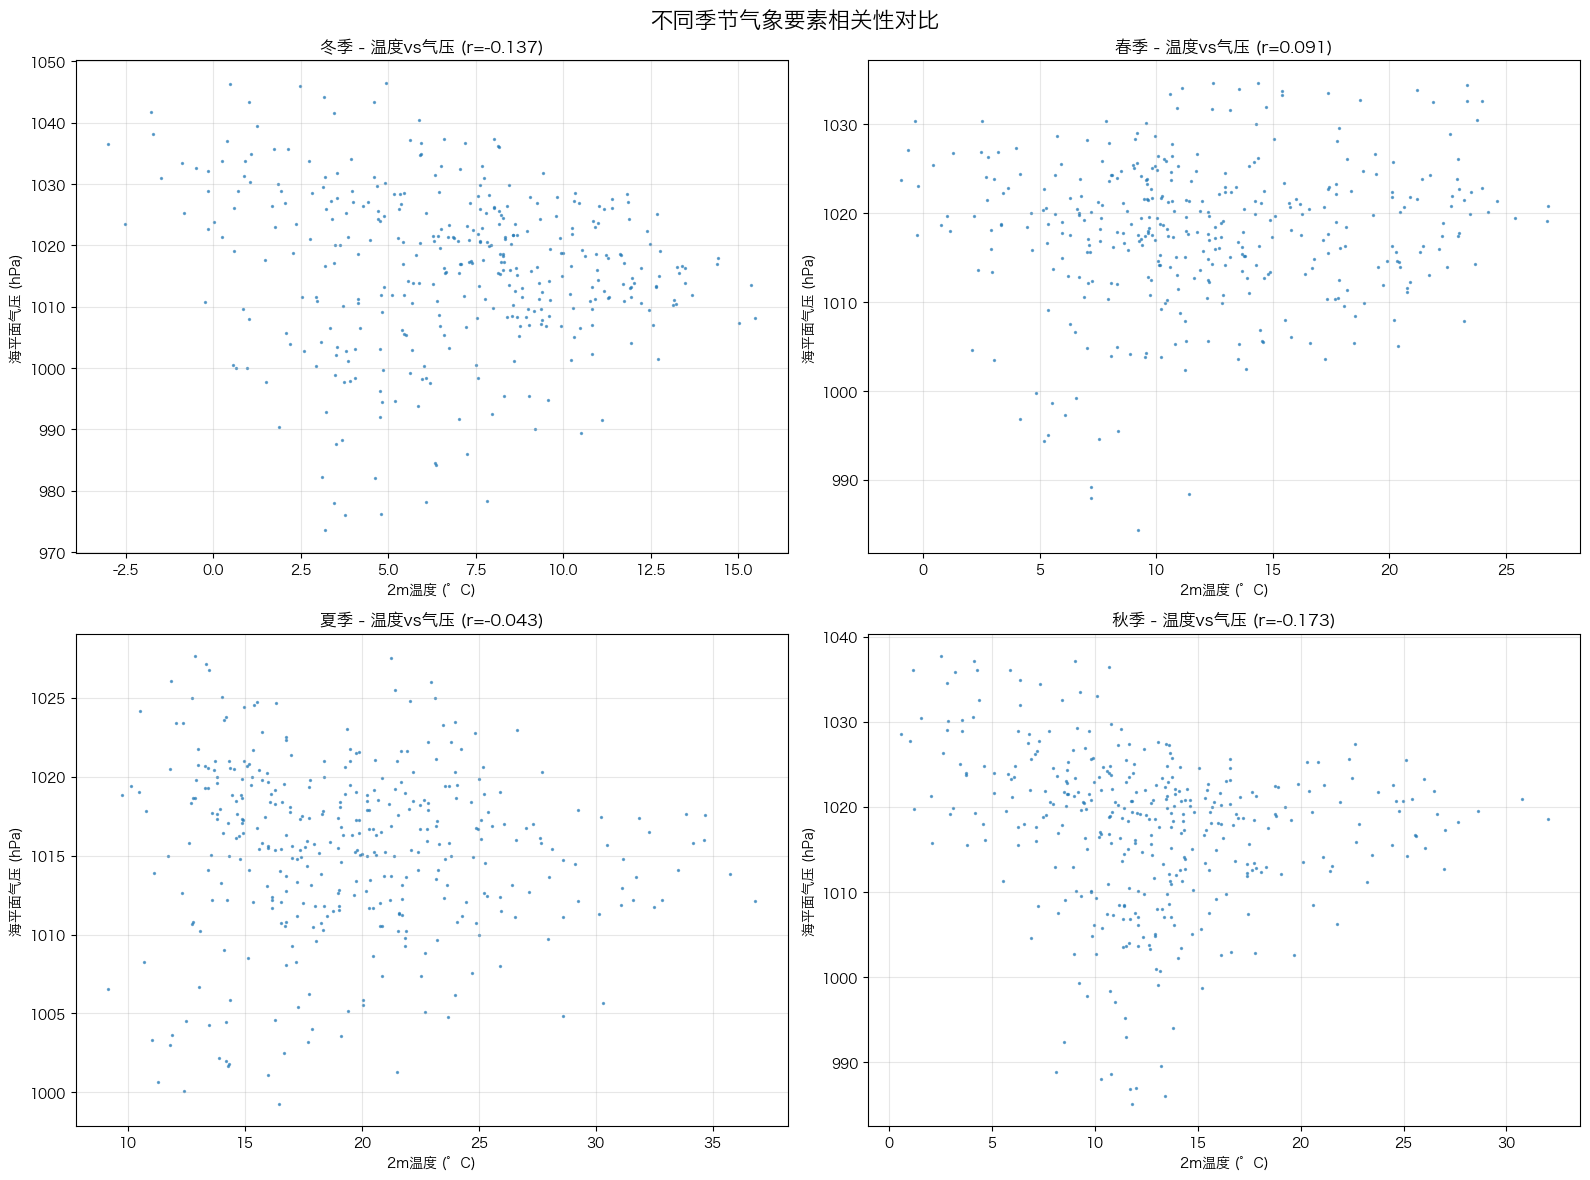

In [13]:
# 分析不同季节的相关性差异
print("\n=== 分季节相关性分析 ===")
seasonal_correlations = {}

for season in [1, 2, 3, 4]:
    season_data = df[df['season'] == season]
    season_corr = season_data[correlation_vars].corr()
    seasonal_correlations[season_names[season]] = season_corr

    print(f"\n{season_names[season]}相关性:")
    print("温度-露点温度:", season_corr.loc['t2m_c', 'd2m_c'].round(3))
    print("温度-气压:", season_corr.loc['t2m_c', 'msl_hpa'].round(3))
    print("气压-风速:", season_corr.loc['msl_hpa', 'wind_speed'].round(3))

# 可视化季节性相关性差异
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('不同季节气象要素相关性对比', fontsize=16)

seasons = [1, 2, 3, 4]
for i, season in enumerate(seasons):
    ax = axes[i//2, i%2]
    season_data = df[df['season'] == season]

    # 绘制温度vs气压的季节性差异
    ax.scatter(season_data['t2m_c'], season_data['msl_hpa'], alpha=0.6, s=2)
    corr = season_data['t2m_c'].corr(season_data['msl_hpa'])
    ax.set_title(f'{season_names[season]} - 温度vs气压 (r={corr:.3f})')
    ax.set_xlabel('2m温度 (°C)')
    ax.set_ylabel('海平面气压 (hPa)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. 极端事件定义和识别

In [14]:
# 定义极端事件阈值（通常使用百分位数方法）
print("=== 极端事件阈值定义 ===")

# 计算各变量的百分位数
percentiles = [5, 10, 90, 95, 99]
extreme_thresholds = {}

for var in ['t2m_c', 'msl_hpa', 'wind_speed', 'tp_mm']:
    thresholds = np.percentile(df[var], percentiles)
    extreme_thresholds[var] = dict(zip(percentiles, thresholds))
    print(f"\n{var} 百分位数阈值:")
    for p, t in zip(percentiles, thresholds):
        print(f"  P{p}: {t:.3f}")

# 识别极端事件
print("\n=== 极端事件识别 ===")

# 高温事件（>95百分位数）
df['high_temp_event'] = df['t2m_c'] > extreme_thresholds['t2m_c'][95]
high_temp_count = df['high_temp_event'].sum()
print(f"高温事件: {high_temp_count} 次 ({high_temp_count/len(df)*100:.2f}%)")

# 低温事件（<5百分位数）
df['low_temp_event'] = df['t2m_c'] < extreme_thresholds['t2m_c'][5]
low_temp_count = df['low_temp_event'].sum()
print(f"低温事件: {low_temp_count} 次 ({low_temp_count/len(df)*100:.2f}%)")

# 强风事件（>95百分位数）
df['high_wind_event'] = df['wind_speed'] > extreme_thresholds['wind_speed'][95]
high_wind_count = df['high_wind_event'].sum()
print(f"强风事件: {high_wind_count} 次 ({high_wind_count/len(df)*100:.2f}%)")

# 强降水事件（>95百分位数，且>0）
df['heavy_precip_event'] = (df['tp_mm'] > extreme_thresholds['tp_mm'][95]) & (df['tp_mm'] > 0)
heavy_precip_count = df['heavy_precip_event'].sum()
print(f"强降水事件: {heavy_precip_count} 次 ({heavy_precip_count/len(df)*100:.2f}%)")

# 极端低压事件（<5百分位数）
df['low_pressure_event'] = df['msl_hpa'] < extreme_thresholds['msl_hpa'][5]
low_pressure_count = df['low_pressure_event'].sum()
print(f"极端低压事件: {low_pressure_count} 次 ({low_pressure_count/len(df)*100:.2f}%)")

=== 极端事件阈值定义 ===

t2m_c 百分位数阈值:
  P5: 2.735
  P10: 4.152
  P90: 22.566
  P95: 24.954
  P99: 31.151

msl_hpa 百分位数阈值:
  P5: 1000.148
  P10: 1004.995
  P90: 1027.122
  P95: 1031.210
  P99: 1037.171

wind_speed 百分位数阈值:
  P5: 1.244
  P10: 1.648
  P90: 6.575
  P95: 7.460
  P99: 8.938

tp_mm 百分位数阈值:
  P5: 0.000
  P10: 0.000
  P90: 0.202
  P95: 0.455
  P99: 1.207

=== 极端事件识别 ===
高温事件: 74 次 (5.05%)
低温事件: 74 次 (5.05%)
强风事件: 74 次 (5.05%)
强降水事件: 74 次 (5.05%)
极端低压事件: 74 次 (5.05%)


2. 极端事件时间分布分析

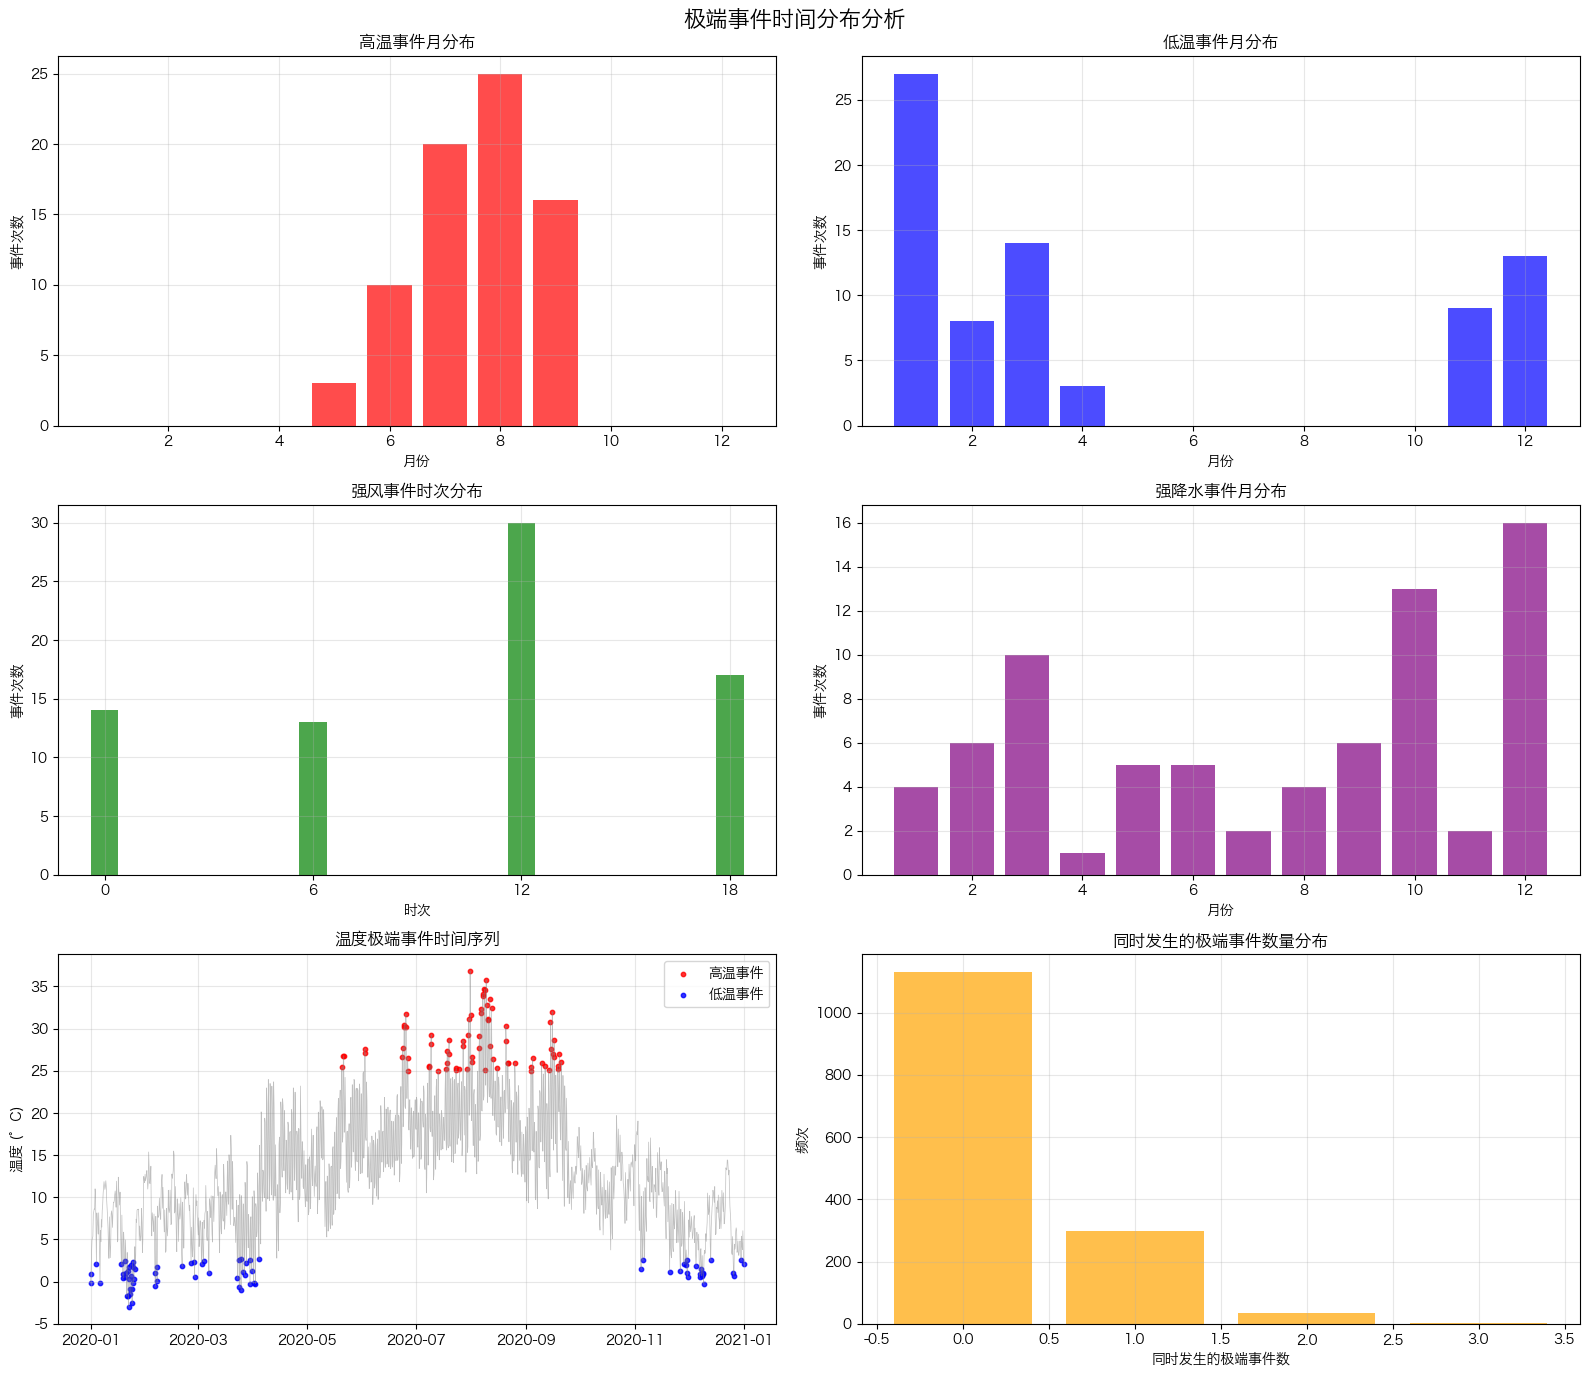

In [15]:
# 分析极端事件的时间分布
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('极端事件时间分布分析', fontsize=16)

# 1. 高温事件月分布
high_temp_monthly = df[df['high_temp_event']].groupby('month').size()
axes[0,0].bar(range(1, 13), [high_temp_monthly.get(i, 0) for i in range(1, 13)],
              color='red', alpha=0.7)
axes[0,0].set_title('高温事件月分布')
axes[0,0].set_xlabel('月份')
axes[0,0].set_ylabel('事件次数')
axes[0,0].grid(True, alpha=0.3)

# 2. 低温事件月分布
low_temp_monthly = df[df['low_temp_event']].groupby('month').size()
axes[0,1].bar(range(1, 13), [low_temp_monthly.get(i, 0) for i in range(1, 13)],
              color='blue', alpha=0.7)
axes[0,1].set_title('低温事件月分布')
axes[0,1].set_xlabel('月份')
axes[0,1].set_ylabel('事件次数')
axes[0,1].grid(True, alpha=0.3)

# 3. 强风事件时次分布
high_wind_hourly = df[df['high_wind_event']].groupby('hour').size()
axes[1,0].bar([0, 6, 12, 18], [high_wind_hourly.get(i, 0) for i in [0, 6, 12, 18]],
              color='green', alpha=0.7)
axes[1,0].set_title('强风事件时次分布')
axes[1,0].set_xlabel('时次')
axes[1,0].set_ylabel('事件次数')
axes[1,0].set_xticks([0, 6, 12, 18])
axes[1,0].grid(True, alpha=0.3)

# 4. 强降水事件月分布
heavy_precip_monthly = df[df['heavy_precip_event']].groupby('month').size()
axes[1,1].bar(range(1, 13), [heavy_precip_monthly.get(i, 0) for i in range(1, 13)],
              color='purple', alpha=0.7)
axes[1,1].set_title('强降水事件月分布')
axes[1,1].set_xlabel('月份')
axes[1,1].set_ylabel('事件次数')
axes[1,1].grid(True, alpha=0.3)

# 5. 极端事件时间序列
axes[2,0].plot(df['valid_time'], df['t2m_c'], 'gray', alpha=0.5, linewidth=0.5)
extreme_dates = df[df['high_temp_event'] | df['low_temp_event']]['valid_time']
extreme_temps = df[df['high_temp_event'] | df['low_temp_event']]['t2m_c']
high_temp_dates = df[df['high_temp_event']]['valid_time']
high_temp_vals = df[df['high_temp_event']]['t2m_c']
low_temp_dates = df[df['low_temp_event']]['valid_time']
low_temp_vals = df[df['low_temp_event']]['t2m_c']

axes[2,0].scatter(high_temp_dates, high_temp_vals, color='red', s=10, alpha=0.8, label='高温事件')
axes[2,0].scatter(low_temp_dates, low_temp_vals, color='blue', s=10, alpha=0.8, label='低温事件')
axes[2,0].set_title('温度极端事件时间序列')
axes[2,0].set_ylabel('温度 (°C)')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# 6. 多个极端事件的共现分析
df['multiple_extreme'] = (df['high_temp_event'].astype(int) +
                          df['low_temp_event'].astype(int) +
                          df['high_wind_event'].astype(int) +
                          df['heavy_precip_event'].astype(int) +
                          df['low_pressure_event'].astype(int))

extreme_counts = df['multiple_extreme'].value_counts().sort_index()
axes[2,1].bar(extreme_counts.index, extreme_counts.values, alpha=0.7, color='orange')
axes[2,1].set_title('同时发生的极端事件数量分布')
axes[2,1].set_xlabel('同时发生的极端事件数')
axes[2,1].set_ylabel('频次')
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

3. 异常检测算法应用

In [16]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

print("\n=== 异常检测算法应用 ===")

# 方法1: 基于Z-score的异常检测
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

# 方法2: 基于IQR的异常检测
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# 对温度进行异常检测
temp_zscore_outliers = detect_outliers_zscore(df['t2m_c'])
temp_iqr_outliers = detect_outliers_iqr(df['t2m_c'])

print("温度异常检测结果:")
print(f"Z-score方法检测到异常: {temp_zscore_outliers.sum()} 个 ({temp_zscore_outliers.sum()/len(df)*100:.2f}%)")
print(f"IQR方法检测到异常: {temp_iqr_outliers.sum()} 个 ({temp_iqr_outliers.sum()/len(df)*100:.2f}%)")

# 方法3: 使用Isolation Forest进行多维异常检测
features_for_anomaly = ['t2m_c', 'msl_hpa', 'wind_speed', 'relative_humidity']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_for_anomaly])

# 使用Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 假设5%为异常
df['anomaly_score'] = iso_forest.fit_predict(scaled_features)
df['is_anomaly'] = df['anomaly_score'] == -1

anomaly_count = (df['anomaly_score'] == -1).sum()
print(f"Isolation Forest检测到异常: {anomaly_count} 个 ({anomaly_count/len(df)*100:.2f}%)")


=== 异常检测算法应用 ===
温度异常检测结果:
Z-score方法检测到异常: 6 个 (0.41%)
IQR方法检测到异常: 14 个 (0.96%)
Isolation Forest检测到异常: 74 个 (5.05%)


4. 异常事件特征分析


=== 异常事件特征分析 ===
异常事件 vs 正常事件特征对比:
------------------------------------------------------------
变量              正常均值         异常均值         差异        
------------------------------------------------------------
t2m_c           12.667       16.254       3.587     
msl_hpa         1017.001     1010.472     -6.529    
wind_speed      3.799        4.351        0.552     
relative_humidity 75.336       61.761       -13.575   
tp_mm           0.074        0.167        0.093     


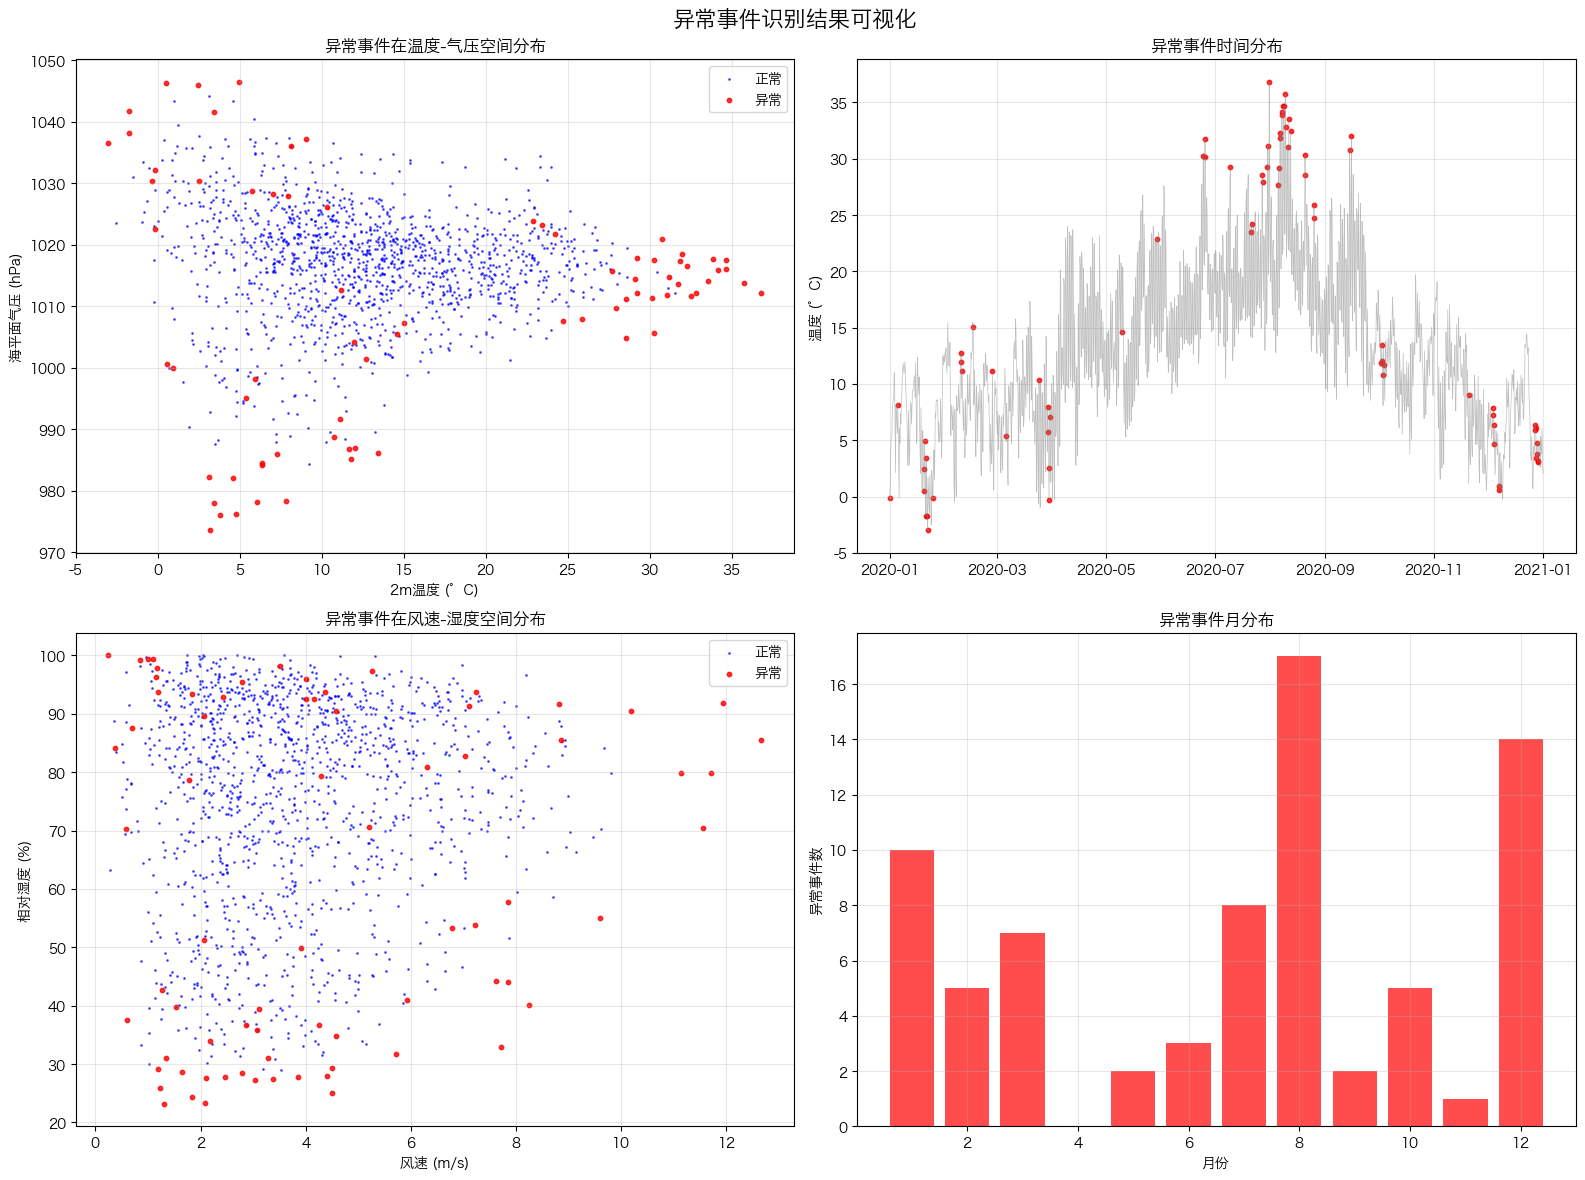

In [17]:
# 分析异常事件的特征
print("\n=== 异常事件特征分析 ===")

# 分析异常点的气象特征
anomaly_data = df[df['is_anomaly']]
normal_data = df[~df['is_anomaly']]

comparison_vars = ['t2m_c', 'msl_hpa', 'wind_speed', 'relative_humidity', 'tp_mm']
print("异常事件 vs 正常事件特征对比:")
print("-" * 60)
print(f"{'变量':<15} {'正常均值':<12} {'异常均值':<12} {'差异':<10}")
print("-" * 60)

for var in comparison_vars:
    normal_mean = normal_data[var].mean()
    anomaly_mean = anomaly_data[var].mean()
    diff = anomaly_mean - normal_mean
    print(f"{var:<15} {normal_mean:<12.3f} {anomaly_mean:<12.3f} {diff:<10.3f}")

# 可视化异常事件
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('异常事件识别结果可视化', fontsize=16)

# 1. 异常事件在温度-气压空间的分布
axes[0,0].scatter(normal_data['t2m_c'], normal_data['msl_hpa'],
                  alpha=0.6, s=1, color='blue', label='正常')
axes[0,0].scatter(anomaly_data['t2m_c'], anomaly_data['msl_hpa'],
                  alpha=0.8, s=10, color='red', label='异常')
axes[0,0].set_title('异常事件在温度-气压空间分布')
axes[0,0].set_xlabel('2m温度 (°C)')
axes[0,0].set_ylabel('海平面气压 (hPa)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. 异常事件时间分布
axes[0,1].plot(df['valid_time'], df['t2m_c'], 'gray', alpha=0.5, linewidth=0.5)
axes[0,1].scatter(anomaly_data['valid_time'], anomaly_data['t2m_c'],
                  color='red', s=10, alpha=0.8)
axes[0,1].set_title('异常事件时间分布')
axes[0,1].set_ylabel('温度 (°C)')
axes[0,1].grid(True, alpha=0.3)

# 3. 异常事件风速分布
axes[1,0].scatter(normal_data['wind_speed'], normal_data['relative_humidity'],
                  alpha=0.6, s=1, color='blue', label='正常')
axes[1,0].scatter(anomaly_data['wind_speed'], anomaly_data['relative_humidity'],
                  alpha=0.8, s=10, color='red', label='异常')
axes[1,0].set_title('异常事件在风速-湿度空间分布')
axes[1,0].set_xlabel('风速 (m/s)')
axes[1,0].set_ylabel('相对湿度 (%)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. 异常事件月分布
anomaly_monthly = anomaly_data.groupby('month').size()
axes[1,1].bar(range(1, 13), [anomaly_monthly.get(i, 0) for i in range(1, 13)],
              color='red', alpha=0.7)
axes[1,1].set_title('异常事件月分布')
axes[1,1].set_xlabel('月份')
axes[1,1].set_ylabel('异常事件数')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. 特征工程和数据准备

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("=== 特征工程 ===")

# 构建用于聚类的特征集
# 基础气象特征
clustering_features = ['t2m_c', 'd2m_c', 'msl_hpa', 'wind_speed', 'u10', 'v10', 'tp_mm']

# 添加衍生特征
df['temp_dewpoint_diff'] = df['t2m_c'] - df['d2m_c']  # 温露差
df['relative_humidity'] = 100 * np.exp((17.625 * df['d2m_c']) / (243.04 + df['d2m_c'])) / np.exp((17.625 * df['t2m_c']) / (243.04 + df['t2m_c']))
df['wind_direction'] = np.arctan2(df['v10'], df['u10']) * 180 / np.pi  # 风向
df['wind_direction'][df['wind_direction'] < 0] += 360  # 转换为0-360度

# 添加时间特征
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)

# 最终特征集
final_features = ['t2m_c', 'msl_hpa', 'wind_speed', 'relative_humidity',
                  'temp_dewpoint_diff', 'tp_mm', 'u10', 'v10',
                  'cos_hour', 'sin_hour', 'cos_month', 'sin_month']

print("用于聚类的特征:")
for i, feature in enumerate(final_features, 1):
    print(f"{i:2d}. {feature}")

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[final_features])

print(f"\n标准化后的数据形状: {X_scaled.shape}")

=== 特征工程 ===
用于聚类的特征:
 1. t2m_c
 2. msl_hpa
 3. wind_speed
 4. relative_humidity
 5. temp_dewpoint_diff
 6. tp_mm
 7. u10
 8. v10
 9. cos_hour
10. sin_hour
11. cos_month
12. sin_month

标准化后的数据形状: (1464, 12)


2. 降维和可视化准备


=== 主成分分析 ===
降维后维度: 9
各主成分解释方差比:
PC1: 0.300
PC2: 0.174
PC3: 0.107
PC4: 0.085
PC5: 0.084
前5个主成分累计解释方差: 0.750


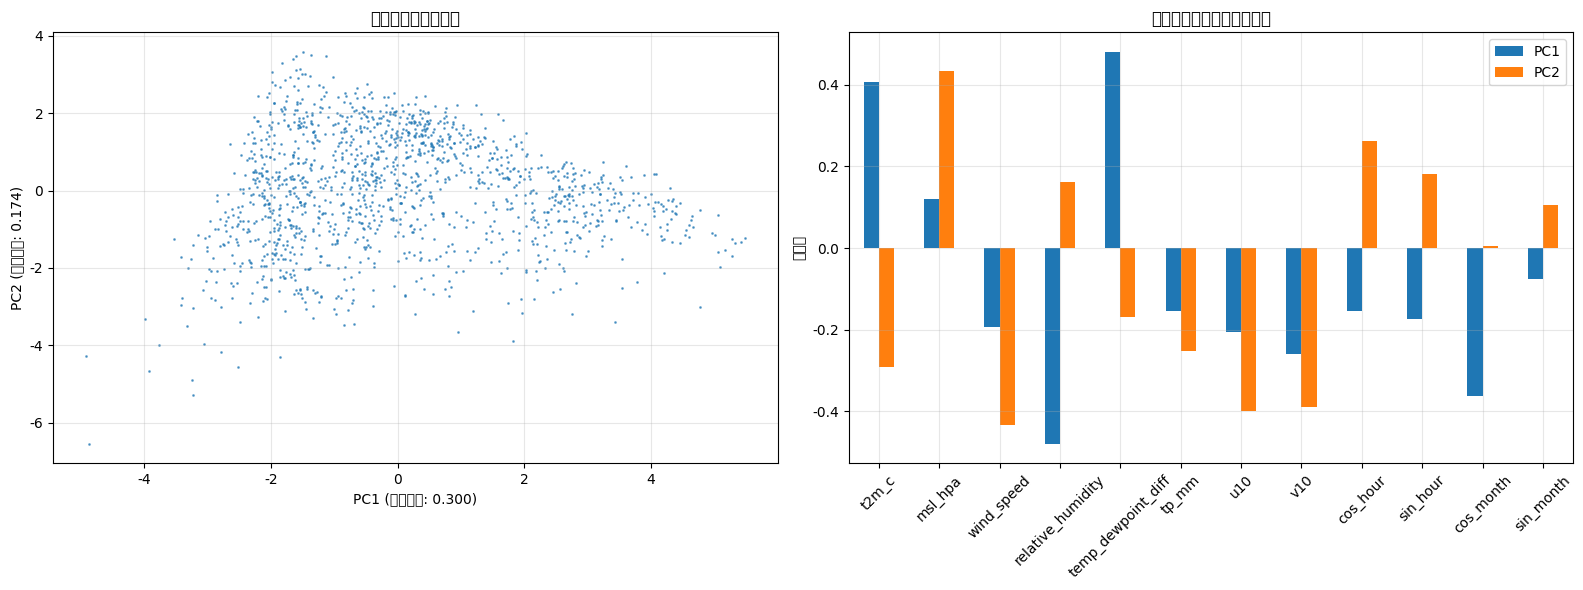


前两个主成分的特征贡献:
                      PC1    PC2
t2m_c               0.405 -0.291
msl_hpa             0.121  0.433
wind_speed         -0.194 -0.433
relative_humidity  -0.478  0.163
temp_dewpoint_diff  0.480 -0.169
tp_mm              -0.153 -0.252
u10                -0.206 -0.399
v10                -0.259 -0.389
cos_hour           -0.155  0.261
sin_hour           -0.173  0.180
cos_month          -0.363  0.005
sin_month          -0.077  0.105


In [22]:
# 使用PCA进行降维可视化
print("\n=== 主成分分析 ===")
pca = PCA(n_components=0.95)  # 保留95%的方差
X_pca = pca.fit_transform(X_scaled)

print(f"降维后维度: {X_pca.shape[1]}")
print("各主成分解释方差比:")
for i, ratio in enumerate(pca.explained_variance_ratio_[:5], 1):
    print(f"PC{i}: {ratio:.3f}")
print(f"前5个主成分累计解释方差: {pca.explained_variance_ratio_[:5].sum():.3f}")

# 可视化前两个主成分
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA散点图
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=1)
axes[0].set_xlabel(f'PC1 (解释方差: {pca.explained_variance_ratio_[0]:.3f})')
axes[0].set_ylabel(f'PC2 (解释方差: {pca.explained_variance_ratio_[1]:.3f})')
axes[0].set_title('主成分空间数据分布')
axes[0].grid(True, alpha=0.3)

# 特征贡献度
feature_contributions = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=final_features
)

feature_contributions.plot(kind='bar', ax=axes[1])
axes[1].set_title('前两个主成分的特征贡献度')
axes[1].set_ylabel('贡献度')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n前两个主成分的特征贡献:")
print(feature_contributions.round(3))

3. 确定最优聚类数量


=== 确定最优聚类数量 ===
k=2: 惯性=13851.69, 轮廓系数=0.208
k=3: 惯性=11829.86, 轮廓系数=0.186
k=4: 惯性=10784.01, 轮廓系数=0.168
k=5: 惯性=9966.90, 轮廓系数=0.176
k=6: 惯性=9393.17, 轮廓系数=0.167
k=7: 惯性=8950.71, 轮廓系数=0.165
k=8: 惯性=8562.63, 轮廓系数=0.152
k=9: 惯性=8203.22, 轮廓系数=0.150
k=10: 惯性=7871.11, 轮廓系数=0.157


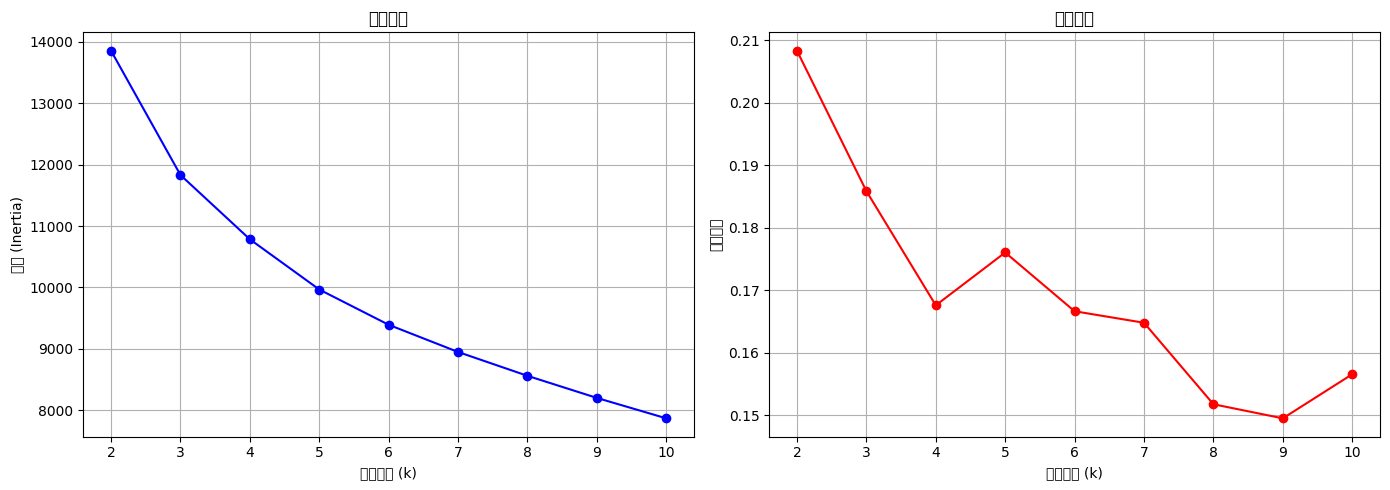


推荐的聚类数量: 2 (轮廓系数最高: 0.208)


In [23]:
# 使用肘部法则和轮廓系数确定最优聚类数
print("\n=== 确定最优聚类数量 ===")

k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(sil_score)

    print(f"k={k}: 惯性={kmeans.inertia_:.2f}, 轮廓系数={sil_score:.3f}")

# 可视化选择结果
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 肘部法则
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('聚类数量 (k)')
axes[0].set_ylabel('惯性 (Inertia)')
axes[0].set_title('肘部法则')
axes[0].grid(True)

# 轮廓系数
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('聚类数量 (k)')
axes[1].set_ylabel('轮廓系数')
axes[1].set_title('轮廓系数')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 找到最优k值
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n推荐的聚类数量: {best_k} (轮廓系数最高: {max(silhouette_scores):.3f})")